In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "danilsaidyllin"
os.environ['KAGGLE_KEY'] = "73c92f5f890a3f0ff9aa08bc2088f041"
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:23<00:00, 29.1MB/s]
100% 812M/812M [00:23<00:00, 36.8MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import os

import zipfile

In [ ]:
import shutil

# Подготовка данных

Для ускоренного обучения необходимо использовать GPU

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Разархивируем данные

In [ ]:
!unzip /content/dogs-vs-cats.zip

Archive:  /content/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip /content/test1.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/5

In [ ]:
!unzip /content/train.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/d

In [ ]:
import random
from PIL import Image
import glob
from pathlib import Path

In [ ]:
base_dir = '/content/dogs_vs_cats'
os.mkdir(base_dir)

Создаем папки с категориями dog, cat в зависимости от названий файлов, также разобьем тренировочные данные на train, test

In [ ]:
train_dir = os.path.join(base_dir , 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir , 'test')
os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir , 'cat')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir , 'dog')
os.mkdir(train_dogs_dir)

test_cats_dir = os.path.join(test_dir , 'cat')
os.mkdir(test_cats_dir) #

test_dogs_dir = os.path.join(test_dir , 'dog')
os.mkdir(test_dogs_dir)

FileExistsError: ignored

In [ ]:
dir_path = '/content/train'

cat_count = 0
dog_count= 0
for i in os.listdir(dir_path):
    if i.startswith('cat.'):
        cat_count += 1
    elif i.startswith('dog.'):
        dog_count += 1

print(f"Number of cat images: {cat_count}")
print(f"Number of dog images: {dog_count}")

Number of cat images: 12500
Number of dog images: 12500


Разобьем выборку на 10000 для каждой категории в train и 2500 test

In [ ]:
original_dataset_dir = '/content/train'

fnames = ['cat.{}.jpg'.format(i) for i in range(10001)]
for fname in fnames:
  src = os.path.join(original_dataset_dir , fname)
  dst = os.path.join(train_cats_dir , fname)
  shutil.copyfile(src , dst)


fnames = ['cat.{}.jpg'.format(i) for i in range(10001,12500)]
for fname in fnames:
  src= os.path.join(original_dataset_dir , fname)
  dst= os.path.join(test_cats_dir, fname)
  shutil.copyfile(src,dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(10001)]
for fname in fnames:
  src = os.path.join(original_dataset_dir , fname)
  dst = os.path.join(train_dogs_dir ,fname)
  shutil.copyfile(src,dst)


fnames = ['dog.{}.jpg'.format(i) for i in range(10001,12500)]
for fname in fnames:
  src= os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir , fname)
  shutil.copyfile(src, dst)

In [ ]:
print(f'Total training cat images {len(os.listdir(train_cats_dir))}')
print(f'Total test cat images {len(os.listdir(test_cats_dir))}')
print(f'Total training dog images {len(os.listdir(train_dogs_dir))}')
print(f'Total test cat images {len(os.listdir(test_dogs_dir))}')

Total training cat images 10001
Total test cat images 2500
Total training dog images 10001
Total test cat images 2500


In [ ]:
train_dir = "/content/dogs_vs_cats/train"
test_dir = "/content/dogs_vs_cats/test"
train_dir, test_dir

('/content/dogs_vs_cats/train', '/content/dogs_vs_cats/test')

In [ ]:
image_path = "/content/dogs_vs_cats"

Random image path: /content/dogs_vs_cats/test/dog/dog.10727.jpg
Image class: dog
Image height: 287
Image width: 339


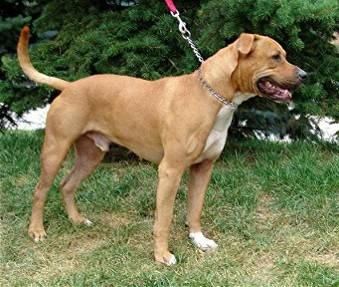

In [ ]:
random.seed(10424)
image_path_list= glob.glob(f"{image_path}/*/*/*.jpg")

random_image_path = random.choice(image_path_list)

image_class = Path(random_image_path).parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

Данные из учебной выборки необходимо преобразовать

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

data_transform = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

Воспользуемся готовым классом из datasets для преобразования данных в датасет

In [ ]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 20002
    Root location: /content/dogs_vs_cats/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 5000
    Root location: /content/dogs_vs_cats/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
class_names = train_data.classes
print("Class names: ",class_names)

class_dict = train_data.class_to_idx
print("Class names as a dict: ",class_dict)

print("The lengths of the training and test sets: ", len(train_data), len(test_data))

Class names:  ['cat', 'dog']
Class names as a dict:  {'cat': 0, 'dog': 1}
The lengths of the training and test sets:  20002 5000


In [ ]:
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79fdff6fff10>,
 <torch.utils.data.dataloader.DataLoader at 0x79fdff6ffeb0>)

In [ ]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

In [ ]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 20002
     Root location: /content/dogs_vs_cats/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 5000
     Root location: /content/dogs_vs_cats/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [ ]:
BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x79fe01c07ee0>,
 <torch.utils.data.dataloader.DataLoader at 0x79fe01c07ca0>)

## Создание модели

Создаем класс модели с архитектурой приведенной ниже

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 512, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=512*3*3, out_features=2))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x
model = ImageClassifier().to(device)

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.5 MB/s eta 0:00:00


In [ ]:
from torchmetrics.classification import BinaryPrecision, BinaryRecall


In [ ]:
precision = BinaryPrecision().to(device)
recall = BinaryRecall().to(device)

Функции для рассчета ошибки и некоторых метрик модели

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()

    train_loss, train_acc, train_prec, train_recall = 0, 0, 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        train_prec += float(precision(y_pred_class, y))
        train_recall += float(recall(y_pred_class, y))

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    train_prec = train_prec / len(dataloader)
    train_recall = train_recall / len(dataloader)

    return train_loss, train_acc, train_prec, train_recall

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()

    test_loss, test_acc, test_prec, test_recall = 0, 0 , 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            test_prec += float(precision(test_pred_labels, y))
            test_recall += float(recall(test_pred_labels, y))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    test_prec = test_prec / len(dataloader)
    test_recall = test_recall / len(dataloader)
    return test_loss, test_acc, test_prec, test_recall

Создаем функцию обучения моделей, так же добавим словарь результатов для дальнейшего отслеживания и построения графиков

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_prec, train_recall = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc, test_prec, test_recall = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"train_prec: {train_prec:.4f} | "
            f"train_recall: {train_recall:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"test_prec: {test_prec:.4f} | "
            f"test_recall: {test_recall:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

from timeit import default_timer as timer
start_time = timer()

model_results = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3067 | train_acc: 0.8660 | train_prec: 0.8676 | train_recall: 0.8717 | test_loss: 0.3104 | test_acc: 0.8639test_prec: 79.5032test_recall: 66.1276
Epoch: 2 | train_loss: 0.3057 | train_acc: 0.8635 | train_prec: 0.8650 | train_recall: 0.8664 | test_loss: 0.3127 | test_acc: 0.8662test_prec: 79.4613test_recall: 65.4155
Epoch: 3 | train_loss: 0.2595 | train_acc: 0.8851 | train_prec: 0.8854 | train_recall: 0.8850 | test_loss: 0.2372 | test_acc: 0.8969test_prec: 79.5032test_recall: 75.7542
Epoch: 4 | train_loss: 0.2405 | train_acc: 0.8931 | train_prec: 0.8919 | train_recall: 0.8994 | test_loss: 0.2500 | test_acc: 0.9080test_prec: 79.5032test_recall: 73.5843
Epoch: 5 | train_loss: 0.2187 | train_acc: 0.9036 | train_prec: 0.9016 | train_recall: 0.9086 | test_loss: 0.2998 | test_acc: 0.8822test_prec: 79.4672test_recall: 77.7041
Epoch: 6 | train_loss: 0.1923 | train_acc: 0.9176 | train_prec: 0.9185 | train_recall: 0.9201 | test_loss: 0.2160 | test_acc: 0.9140test_prec: 79

На 20 эпохе accuracy равняется 94.1, так как классы сбалансированы точность в 94.1% является удовлетворительной

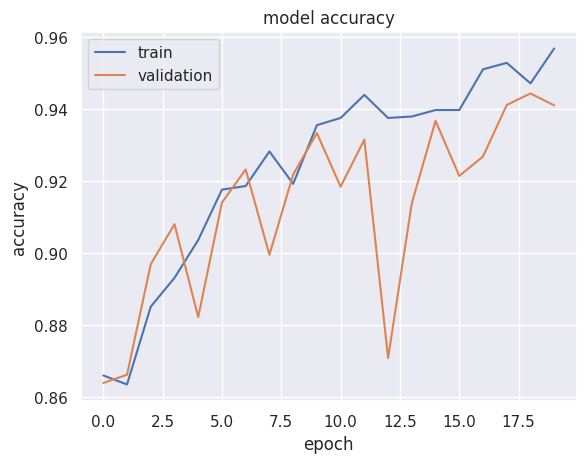

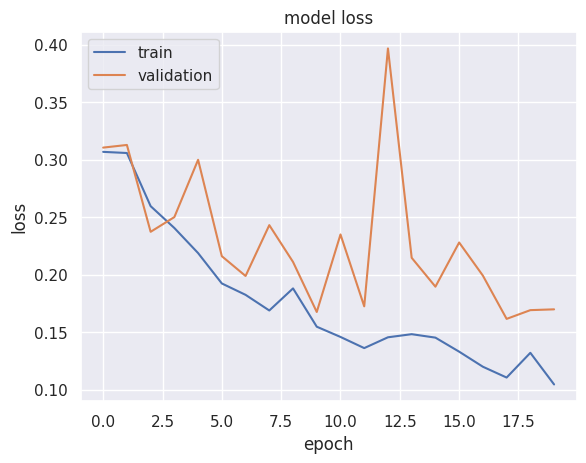

In [ ]:
plt.plot(results['train_acc'])
plt.plot(results['test_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
torch.save(model.state_dict(),'/content/model.pth' )